# Predicting Job Satisfaction of Software Developers
In this research project a classification model will be created that tries to predict the Job Satisfaction of Software Developers using the survey results from the Stack Overflow survey of 2018.

## Describing the dataset
[Stack Overflow](https://stackoverflow.com/) is a website where you can ask and answer software related questions. It is a platform where millions of programmers, software developers, software engineers, etc. meet every day to learn form each other. Stack Overflow itself is aware of the enormous popularity of their platform and for this reason they keep a annual survey to get general insight about the average software engineer in relation to his/her field of work.

Every year the results of the survey will get published on their website (cleaned and in csv format). Multiple datasets (one for each year since 2015) are available for analysis. For this project the survey results of 2018 will be used exclusively. The main reason for this choice is recency and the completeness of the results. The 2018 survey results were filled in by around 100.000 software developers, most of which answered 129 different questions. These questions are about job satisfaction, salary, favourite programming languages, weekly exercise, company size, etc. This large variety of questions provides a source of interesting research opportunities.

**Source of the dataset**<br />
Stack Overflow Developer Survey 2018 (186 MB): https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey


**Data description:**<br />
The Stack Overflow survey results of 2018 has in total 98855 rows and 129 columns. Some of these columns consist of only numerical data, like: 'Salary' and 'ConvertedSalary'. All the other columns are categorical. The categorical columns are devidable over three types of columns:
- Values denoted in text. E.g. 'Yes', 'No', 'United States', 'Employed part-time', etc.
- Values denoted in ';' seperated lists. E.g. 'Python;Java;C#', 'Windows;Linux;, etc.
- Values denoted in numbers. E.g. 1, 2, 3, 4, etc. (for rankings)

Textual input can't be interpreted easily by the average Machine Learning algorithm. Therefore, preprocessing of the original dataset is needed, so it can be used for further analysis. A [notebook](./dataset_preprocessing.ipynb) is created that is dedicted to preprocessing the Stack Overflow survey dataset in the following ways:
- Drop rows with missing values in the column 'JobSatisfaction'. The column 'JobSatisfaction' is the target value that will be used for analysis. It is not desirable to have missing values for a target feature, because the value NaN doesn't refer to valid classification value.
- Drop unimportant columns. Some columns can be left out because they have no correlation with the target column 'JobSatisfaction', are redundant or have too many missing values (80%).
- Preprocess values dentoed in ';' seperated lists. List values such as 'Python;Java;C#' can't be used as input for a Machine Learning algorithm. First, the value has to be numerical. Second, numerification of the ';' value as is will result a unique class for every unique list. It is instead needed to get a unique class for every language present in the list.
- Encode text to numerical values. Text isn't easy to interpret for Machine Learning algorithms. To solve this problem all text-formatted values will be converted to numerical values.
- (optional) Impute missing values. A lot of data is missing, this missing data can be imputed with statistical values (e.g. mean, mode, etc.). Both the imputed and not-imputed dataset will be used in the analysis. (The one that will perform better will be chosen)

The above steps will result in a preprocessed data set with 69276 rows and 410 columns.<br />
The data will be tranformed as follows:<br />

| Student | Programming Language | Country        |
|:-------:|:--------------------:|:--------------:|
| Yes     | Python;Java;C#       | Kenya          |
| No      | Python;C#            | United Kingdom |
| Yes     | Java;C#              | United States  |

| Student | Python | Java | C# | Country |
|:-------:|:------:|:----:|:--:|:-------:|
| 1       | 1      | 1    | 1  | 0       |
| 0       | 1      | 0    | 1  | 1       |
| 1       | 0      | 1    | 1  | 2       |

## Research
Research will be conducted on the job satisfaction of software developers. The dataset, as described above, will be used to create a classifaction model that predicts the job statisfaction of software developers. The following research question will be answered:

**Can an accurate model be created, given the features denoted in the survey, to predict the job satisfaction of software developers?**

The model will be seen as accurate if at least 90% of the predictions are the same as the target values (column 'JobSatisfaction'). On top of the research question, a initial hypothesis can be made:

**Salary and career satisfaction are the main influencors of job satisfaction, and is therefore responsible for a high accuracy classification model.**

This hypothesis will be either approved or rejected accoring to the reseach results.

## Exploration
Initial exploration of the data gives insight of the data itself and a better intuiting while conducting the research.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import the preprocessed dataset
Only the not-imputed dataset will be imported for exploration. This is because the not-imputed dataset will yield more accurate visualization in contrast to the imputed dataset. 

In [2]:
# Import preprocessed not-imputed dataset
so_survey = pd.read_csv('./dataset/so_survey_prepped.csv')

# Import the mappings for decoding purposes
so_mappings = pd.read_csv('./dataset/so_survey_mappings.csv')

In [3]:
# Show first three entries of so_survey data frame
so_survey.head(3)

,Hobby,OpenSource,Country,is_student,Employment,FormalEducation,UndergradMajor,CompanySize,YearsCoding,YearsCodingProf,...,Bisexual or Queer,Gay or Lesbian,Straight or heterosexual,Black or of African descent,East Asian,Hispanic or Latino/Latina,Middle Eastern,"Native American, Pacific Islander, or Indigenous Australian",South Asian,White or of European descent
0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,1,1,0,0,0,0,0,0
1,0,1,1,0.0,1,0.0,1.0,1.0,1.0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,1,2,0.0,1,1.0,2.0,0.0,2.0,2,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Show first three entries of so_mappings data frame
so_mappings.head(3)

,Hobby,OpenSource,Country,is_student,Employment,FormalEducation,UndergradMajor,CompanySize,YearsCoding,YearsCodingProf,...,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,Exercise,EducationParents,Age,Dependents
0,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,3-5 years,3-5 years,...,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,3 - 4 times per week,"Bachelor’s degree (BA, BS, B.Eng., etc.)",25 - 34 years old,Yes
1,No,Yes,United Kingdom,"Yes, part-time",Employed full-time,Associate degree,"A natural science (ex. biology, chemistry, phy...","10,000 or more employees",30 or more years,18-20 years,...,A little bit interested,A little bit interested,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,3 - 4 times per week,Daily or almost every day,Some college/university study without earning ...,35 - 44 years old,No
2,NaN,NaN,United States,"Yes, full-time","Independent contractor, freelancer, or self-em...",Some college/university study without earning ...,"Computer science, computer engineering, or sof...",100 to 499 employees,24-26 years,6-8 years,...,Somewhat interested,Somewhat interested,Before 5:00 AM,Over 12 hours,Less than 30 minutes,1 - 2 times per week,I don't typically exercise,"Secondary school (e.g. American high school, G...",18 - 24 years old,NaN


#### Create decode  and encode function
In advance, a generic decode and encode function will be created

In [5]:
def decode_labels(labels, column_name, decoder=so_mappings):
    """ Decodes encoded (preprocessed) labes using a decoder.
    E.g. [0, 1, 0, 0] for column 'Hobby' => ['Yes', 'No', 'Yes', 'Yes']
    """
    decoded_labels = so_mappings[column_name].values
    return [decoded_labels[i] for i in labels]

def encode_labels(labels, column_name, encoder=so_mappings):
    """ Encoded decoded labes using an encoder.
    E.g. ['Yes', 'No', 'Yes', 'Yes'] for column 'Hobby' => [0, 1, 0, 0]
    """
    decoded_labels = so_mappings[column_name].values.tolist()
    return [decoded_labels.index(l) for l in labels]

#### Distribution of salary
Lets see how salary is distributed.

In [6]:
# Make a data frame with column 'ConvertedSalary' and NaN values filtered out
mask = pd.isnull(so_survey['ConvertedSalary']) == False
salaries = so_survey['ConvertedSalary'][mask].values

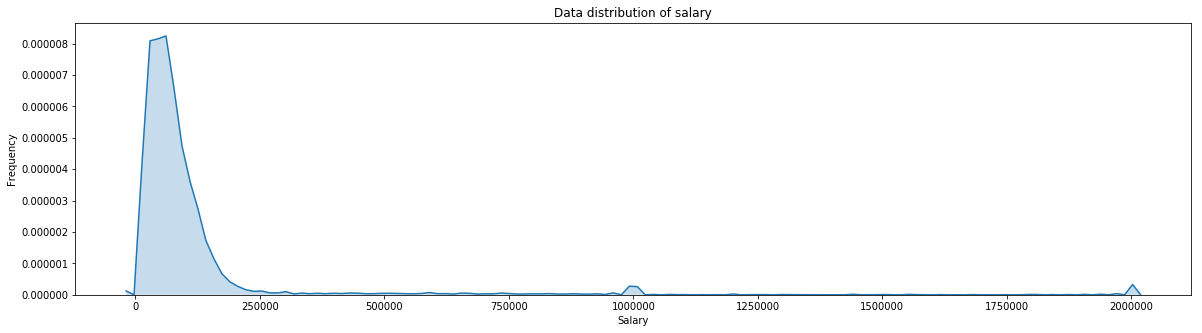

In [7]:
# Plot salary distribution
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary', 
        xlabel='Salary', ylabel='Frequency');

The distribution of salary appears the be very skewed. To reduce the skew, log transformation can be applied on the salaries. But before we can do this, the salaries with value zero needs to be filtered out (logarithm of zero is impossible).

In [8]:
salaries = np.log(salaries[salaries != 0])

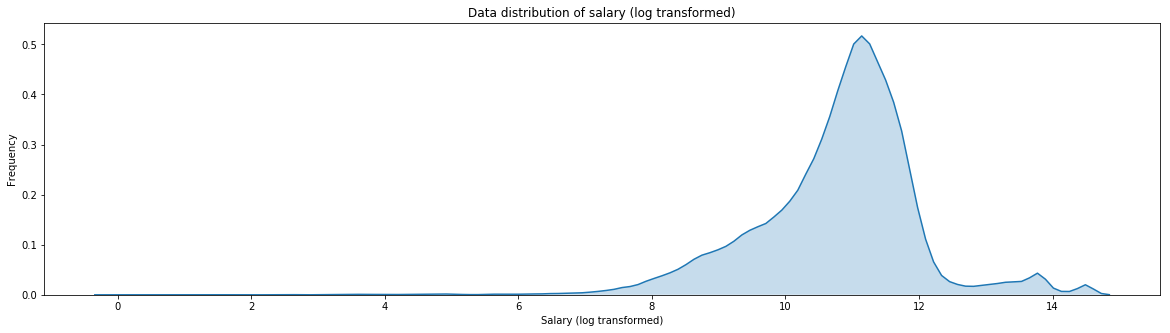

In [9]:
# Plot salary distribution (log transformed)
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary (log transformed)', 
        xlabel='Salary (log transformed)', 
        ylabel='Frequency');

The data distribution has now more the appearance of a gaussian distribution (bell curve shape). Although, the data is still skewed due to the outliers. If the many outliers will cause the classification model to perform badly, the outliers will be removed. This can be done, for example, by pruning the data by $x$ times the standard deviation of the salaries.

#### Average salary per job satisfaction class
Job Satisfaction has 5 different classes: 'Extremely satisfied', 'Extremely dissatisfied', 'Moderately dissatified', 'Moderately satisfied', 'Slightly dissatisfied', 'Slightly satisfied' and 'Neither satisfied nor dissatisfied'. Lets see what the average salary is for each class.

In [10]:
# Get only the data from people that work full-time (yields more accurate results)
employed = so_survey[so_survey['Employment'] == encode_labels(['Employed full-time'], 'Employment')]

# Remove the data with unknown salary and unknown job satisfaction
employed = employed[pd.isnull(employed['ConvertedSalary']) == False]

# Create a new data frame containing only the columns 'JobSatisfaction' and 'Salary (USD/Year)'
employed = employed[['JobSatisfaction', 'ConvertedSalary']]

# Group the data frame by 'JobSatisfaction' to get the average salary for each individual language
employed['ConvertedSalary'] = employed['ConvertedSalary'].astype(float)
employed = employed.groupby('JobSatisfaction').mean().sort_values(by=['ConvertedSalary'])
employed['ConvertedSalary'] = employed['ConvertedSalary'].astype(int) # removes decimal points

# Decode encoded labels to actual (text) values
employed.index = decode_labels(employed.index, 'JobSatisfaction')

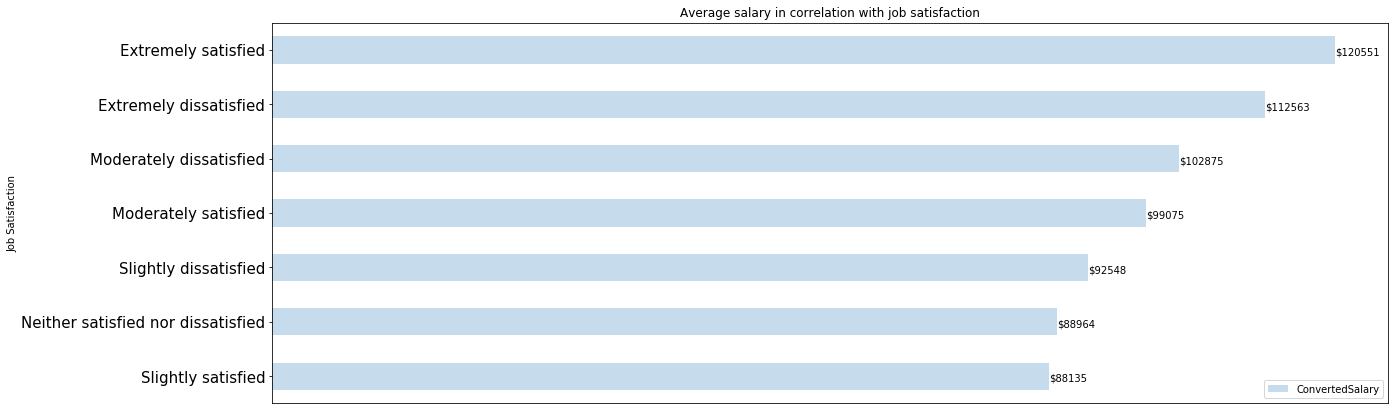

In [11]:
# Plot the data frame to show the job satisfaction with the average salary
barh = employed.plot.barh(figsize=(20, 7), 
                           fontsize=15, 
                           title="Average salary in correlation with job satisfaction",
                           color='#C6DCEC')
for i, v in enumerate(employed.values):
    barh.text(v + .5, i - .1, '$' + str(v[0]), color='black')
barh.set_ylabel("Job Satisfaction")
barh.get_xaxis().set_visible(False)

There appears to be a correlation between job satisfaction and salary. The software developers in the 'extreme' classes get paid more than developers in the 'moderately' classes, which in turn get paid more than the developers in the 'slightly' classes. This could mean that salary has an influence on the severity (extremely, moderately, slightly) of the satisfaction rather than the ranking of the satisfaction.

## Analysis
In this part, some classifiction algorithms will be trained to predict the job satisfaction of software developers. This will be done by implementing the following strategy:
1. Loosely optimize the hyperparameters of a classifier that will be used in the feature selection part. This prevents selecting features with e.g. an overfitted/underfit model.
2. Selecting features with the finetuned classifier. (feature selection is necessary since training classifiers with 409 features and more than 10000 rows is extremely time consuming) 
3. Use the selected features to train and finetune different classifiers.
4. Compare the performance of the different models.

In [12]:
# Import necessary sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#### Setup datasets

In [13]:
# Import preprocessed imputed dataset
so_survey_imputed= pd.read_csv('./dataset/so_survey_prepped_imputed.csv')

# Drop NaN values from preprocessed not-imputed dataset
so_survey.dropna(inplace=True)

#### Setup the features and target values

In [14]:
# Set target (y) 
target = 'JobSatisfaction'
y = so_survey[target]

In [15]:
# Set features (X)
features = [x for x in so_survey.columns if x != target]
X = so_survey[features]

#### Perform feature scaling
A min max scaler will be used to scale the features to values between 0 and 1, resulting in all features having values within the same range. This has some benefits:
+ All features have the same 'weight'. This will help algorithms like SVM (with Gaussian kernel) to perform better.
+ Speeds up gradient descent while training.
+ Improves insight in coefficients. If all features have the same 'weight', resulting coefficient will describe the influence of feature on the target better. This is useful for feature selection.

In [16]:
# Perform feature scaling with min max scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

#### Split into training and testing set
The features and target values will be split into training and testing sets.
The training set will contain 75% of the dataset (randomly selected rows)
The testing set will therefore contain 25% of the dataset.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)

### Loosely optimize hyperparameters
The Random Forest classifier will be used as an estimator for the feature selection step. This has the following benefits:
+ Popular feature selection algorithms like, RFE(CV), are recursively training a classifier. This will take a lot of time. Decision Trees are faster than classifiers such as Neural Networks or Support Vector Machines. 
+ By using a Random Forest the main drawback of Decision Trees (overfitting the training set) will be solved.
+ It isn't known if the classes are linear separatable. A Random Forest is both a linear and a non-linear classifier.
<br><br>The RandomizedSearch method will be used in contrast to GridSearch, because RandomizedSearch doesn't compute all possible computations (hence 'loosely') and is therefore computationally inexpensive.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [20]:
# Create the random grid
random_grid = { 'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap }
# Print grid
[print('%s: %s' % x) for x in random_grid.items()];

n_estimators: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
max_features: ['auto', 'sqrt', 'log2']
max_depth: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]


In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_estimator = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator=rf_estimator, 
                                   param_distributions=random_grid, 
                                   n_iter=15, 
                                   cv=5, 
                                   verbose=2, 
                                   random_state=2, 
                                   n_jobs=-1)

# Fit the random search model
random_search = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 12.2min finished


In [22]:
# Print best cross-validated score
print('Mean cross-validated score of the best estimator: %0.3f' % (random_search.best_score_) )

# Show best parameters
best_rf_params = random_search.best_params_
best_rf_params

Mean cross-validated score of the best estimator: 0.394


{'n_estimators': 1500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 95,
 'bootstrap': False}

### Feature selection
The datasets contain 409 features an more than 10000 rows. Training with such an amount of features can take a very long time for algorithms like SVM (expontential time complexity). The training process becomes much faster by pruning redundant features or by reducing dimensionality. 

#### RFECV (Recursive Feature Elimination with Cross-Validation)
RFE is a method that uses an estimator (in this case a classifier) that assigns weights to features (coefficients). The goals is to recursively select features by considering smaller and smaller sets of features. The least important features are pruned from the current set of features. The CV is used to make a selection of the best number of features.<br>
The estimator that will be used is the Random Forest classifier.

In [30]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

In [25]:
# Instantiate Random Forest classifier
clf = RandomForestClassifier()

In [26]:
# Instantiate and run the RFECV algorithm
f_selector = RFECV(clf, step=1, cv=5)
#f_selector = f_selector.fit(X_scaled, y)

In [27]:
# Create a dataframe that shows the ranking of features
def create_ranking_df(ranking_list, columns):
    ranking = {}
    for i in range(len(ranking_list)):
        rank = ranking_list[i]
        col = columns[i]
        if rank in ranking:
            ranking[rank].append(col)
        else:
            ranking[rank] = [col]
    ranking = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in ranking.items()]))
    return ranking.reindex(sorted(ranking.columns), axis=1)

# Show ranking
ranking = create_ranking_df(f_selector.ranking_, X.columns)
ranking

AttributeError: 'RFECV' object has no attribute 'ranking_'

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(f_selector.grid_scores_) + 1), f_selector.grid_scores_)
plt.show()

In [ ]:
# Show best number of features
print('Optimal number of features %i' % (f_selector.n_features_))

As we can see from the results, two features would be optimal: 'CareerSatisfaction' and 'JobSearchStatus'. The results could also be predicted beforehand, since they both features are highly relatable to jobs in real life.<br>
On the 2nd place is the feature 'ConvertedSalary, on the 3rd place is 'UpdateCV' and on the 4th place is 'HopeFiveYears'. All features are related to jobs.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier